## SQL Query for Power BI

We used the following SQL query to obtain a merged dataset in PowerBI that we could use for python visualizations.

## Python Visualizations with Census Data

Using the Python packages Pandas, Matplotlib, and Seaborn to construct visualizations that would be difficult to achieve in PowerBI. We make use of calculated columns, which are possible in PowerBI, but we felt were simpler to achieve in Python. We make two visualizations, one to explore the differences in demographics of the diabetes EHR dataset and demographics of the census dataset. Next, using the provided census dataset, we explore if the uninsured rate of different groups may explain the differences in demographics between the EHR dataset and census dataset.

In [1]:
import pandas as pd
df = pd.read_csv('..\\data\\diabetic_data.csv')                    #dbo.diabetestemp
df2 = pd.read_csv('..\\data\\2008_race_uninsured_census.csv')      #dbo.race_uninsured_2008

In [2]:
#df.head(3)   #dbo.diabetestemp

In [3]:
#df2.head(3)    #dbo.race_uninsured_2008

In [4]:
df3 = pd.merge(df, df2, how = 'inner', left_on = 'race', right_on = 'Race')    #inner join. df3 outputs results from SQL query

#### Determine Percent Breakdown of Diabetes EHR Dataset by Race

In [5]:
temp = df3.groupby('race')['encounter_id'].count()

In [6]:
df4 = temp.to_frame(name='count')
df4['Type'] = 'Diabetes EHR'
df4['Percent'] = df4['count']/len(df3)*100
df4.reset_index(inplace=True)
df4.rename(columns={'race':'Race'}, inplace=True)
df4

Race  count          Type    Percent
0  AfricanAmerican  19210  Diabetes EHR  19.604641
1            Asian    641  Diabetes EHR   0.654168
2        Caucasian  76099  Diabetes EHR  77.662343
3         Hispanic   2037  Diabetes EHR   2.078847

#### Determine Percent Breakdown of Census US Population by Race

In [7]:
df5 = df3[['Race', 'Total']].groupby('Race')['Total'].mean().to_frame(name = 'count')     #count is in thousands
df5['Type'] = 'Census'
df5['Percent'] = df5['count']/df5['count'].sum()*100           #Divide count by TOtal population
df5.reset_index(inplace=True)
df5

Race   count    Type    Percent
0  AfricanAmerican   36238  Census  11.310767
1            Asian   13321  Census   4.157810
2        Caucasian  224628  Census  70.111897
3         Hispanic   46198  Census  14.419527

In [8]:
final_df = pd.concat([df4, df5])      #comparing Demographics of hospital data vs census data
final_df

Race   count          Type    Percent
0  AfricanAmerican   19210  Diabetes EHR  19.604641
1            Asian     641  Diabetes EHR   0.654168
2        Caucasian   76099  Diabetes EHR  77.662343
3         Hispanic    2037  Diabetes EHR   2.078847
0  AfricanAmerican   36238        Census  11.310767
1            Asian   13321        Census   4.157810
2        Caucasian  224628        Census  70.111897
3         Hispanic   46198        Census  14.419527

#### Visualize Differences in Hospital Demographics vs Census Demographics

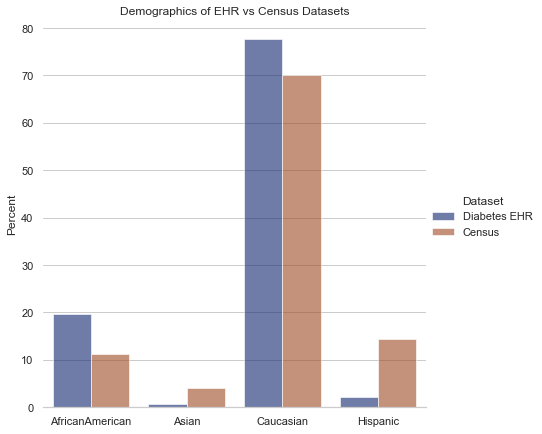

In [9]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=final_df, kind="bar",
    x="Race", y="Percent", hue="Type",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Percent")
g.legend.set_title("Dataset")
g.set(title='Demographics of EHR vs Census Datasets')

The racial breakdown of hospitalization records of diabetes patients from 1998-2008 were plotted against the approximate racial breakdown of the US in 2008. It is observed that African American and Caucasian groups have higher representation in the hospitalization dataset than one might expect based on census data. Likewise, Asian and Hispanic groups have lower representation in the hospitalization dataset than what the census would suggest. This finding shows that hospitization rates may be influenced by external factors in addition to population size.

#### Determine Normalized Uninsured Rate (Uninsured Rate by Race / Mean Overall Uninsured Rate)

In [10]:
df6 = df3[['Race', 'Percent']].groupby('Race')['Percent'].mean().to_frame(name = 'Percent Uninsured')
df6['Type'] = 'Normalized Uninsured Rate'
df6['Ratio'] = df6['Percent Uninsured'] / 14.6    #Mean Overall Uninsured Rate = 14.6%
df6.reset_index(inplace=True)
df6 = df6[['Race','Type','Ratio']]
df6

Race                       Type     Ratio
0  AfricanAmerican  Normalized Uninsured Rate  1.171233
1            Asian  Normalized Uninsured Rate  0.972603
2        Caucasian  Normalized Uninsured Rate  0.876712
3         Hispanic  Normalized Uninsured Rate  2.109589

#### Determine Normalized Diabetes Admittance Rate (Admittance Rate / Population %)

In [11]:
final_df2 = df4.merge(df5, how = 'inner', on = 'Race')
final_df2['Ratio'] = final_df2['Percent_x']/final_df2['Percent_y']
final_df2['Type'] = 'Normalized Diabetes Admittance Rate'
final_df2 = final_df2[['Race','Type','Ratio']]
final_df2

Race                                 Type     Ratio
0  AfricanAmerican  Normalized Diabetes Admittance Rate  1.733273
1            Asian  Normalized Diabetes Admittance Rate  0.157335
2        Caucasian  Normalized Diabetes Admittance Rate  1.107691
3         Hispanic  Normalized Diabetes Admittance Rate  0.144169

In [12]:
concat_df = pd.concat([df6, final_df2])

#### Visualize Possible Relationship of Uninsured Rate vs Hospital Admittance Rate

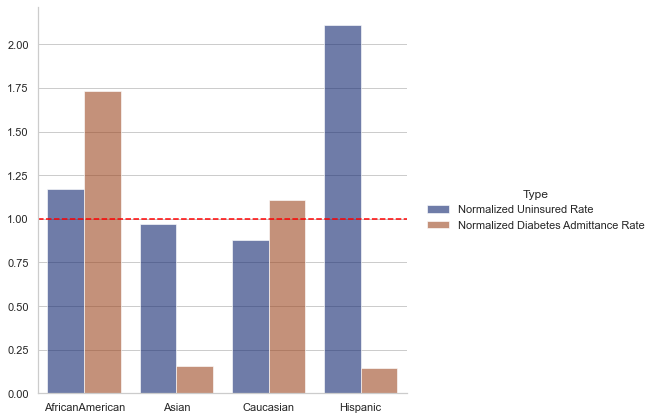

In [13]:
import matplotlib.pyplot as plt

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=concat_df, kind="bar",
    x="Race", y="Ratio", hue='Type',
    ci="sd", palette="dark", alpha=.6, height=6
)

g.map(plt.axhline, y=1, ls='--', c='red')

To explore possible reasons for why different racial groups may be hospitalized for diabetes at different rates, the provided census dataset examining the uninsured rate of different racial groups was utilized. We hypothesize that hospitilization rates for a racial group may have an inverse relationship with uninsured rate. A racial group that has a high uninsured rate may avoid hospitlization due to high financial burden. To test this hypothesis, we sought to plot hospitilization rates vs uninsured rate for racial groups in our datasets. The normalized ratio of hospitalized diabetes patients (%) against US population (%) was plotted for each racial group. A ratio over "1" indicates when a racial group is overly represented in the diabetes EHR dataset based on population size, while a ratio below "1" indicates the inverse. Next the uninsured rate was normalized against the uninsured rate for the US as a whole, which was "14.6%" in 2008. In the resulting plots, we see that our hypothesis appears to be debunked. Hispanic and Caucasian groups fit our hypothesis of inverse relationship between uninsured rate and hospital admittance, but African American and Asian groups do not. 

For additional exploration, it may be prudent to explore other explanations. The CDC 2020 National Diabetes Statistics Report finds that people of hispanic origin have the second highest rate of diagnoses for diabetes at 12.5%, while non-Hispanic white individuals have the lowest rate of diagnoses for diabetes at 7.5%, showing that the discrepency in hospitilizations is not a result of disproporitionate prevelence of diabetes. An alternative explanation may be that Hispanic and Asian groups may have a larger proportion of recent immigrants that may not be comfortable navingating the US Hospital system due to language or cultural barriers. If this were the case, the low rate of hospitalization for Asians and Hispanics may indicate a failure of healthcare access that may be remedied with services such as interpreter access and printing hospital correspondence in additional languages. 

#### Power BI Visualization Python Script 1: Demographics of Diabetes EHR vs Census

The previous python scripts were adapted for PowerBI using the following blocks of code:

#### Power BI Visualization Python Script 2: Normalized Hospital Admittance Demographics vs Uninsured Rate